### DQN confidence prediction using Conformal Prediction

In [1]:
# !pip install Box2D
# !pip install 'gym[all]'
# !pip install pyyaml
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict

import time
import sys
from tqdm import tqdm
import yaml
import re

from dqnetwork import DQNetwork
from agent import Agent

import torch
import torch.nn as nn
import torch.nn.functional as F

from os import listdir, getcwd
from os.path import isabs, join

In [2]:
## Load the environment
env_id = 'LunarLander-v2'
env = gym.make(env_id)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

# Deep Double Q Network with Prioritized Experience Replay Buffers

### Step 1. Load Expert & Evaluation Policies

In [4]:
behavior_agent = Agent(path="../../models/behavior_DQN_policy.pth") #loads behavior policy
eval_agent   = Agent(path="../../models/evaluation_DQN_policy.pth") #loads evaluation policy

Model loaded into local and target networks!
Model loaded into local and target networks!


### Step 2. Running Trajectory rollout

In [5]:
def generate_trajectory(b_agent:Agent, e_agent:Agent):
    """
    Generate Probability for an evaluation agent w.r.t behavior agent.
    @Param:
    1. b_agent - (Agent) Behavior policy.
    2. e_agent - (Agent) Evaluation policy.
    @Return:
    - actions - (np.array[np.array]) set of actions taken by behavior and evaluation agent.
    - probs   - (np.array[np.array[np.array]]) set of probability (shape - env.action_size) 
                for each timestep both agents.
    - states  - (np.array[np.array]) set of states taken by behavior and evaluation agent.
    """
    
    #### 
    states, e_actions, b_actions, e_probs, b_probs = [], [], [], [], []
    ####
    
    state = env.reset()
    total_reward = 0
    done = False #terminal condition
    
    ### set to evaluation mode
    b_agent.qnetwork_local.eval()
    e_agent.qnetwork_local.eval()
    
    while not done:
        b_action, b_prob = b_agent.get_action(state, eps=0) #get action using behavior agent.
        e_action, e_prob = e_agent.get_action(state, eps=0) #get action using evaluation agent.
        
        next_state, reward, done, info = env.step(b_action) #rollout from Expert (behavior) policy
        
        total_reward += reward
        
        #### append ####
        states.append(state) #append states to feature matrix
        
        e_actions.append(e_action) #append evaluation policy actions
        b_actions.append(b_action) #append behavior policy actions
        
        b_probs.append(b_prob) #append stochastic actions of behavior agent
        e_probs.append(e_prob) #append stochastic actions of evaluation agent
        #### append ####
        
        state = next_state
        
    print("TOTAL REWARD FROM EXPERT POLICY", total_reward)
    assert(total_reward >= 200) #conditioned on truth
    return np.array(states), np.array(e_actions), np.array(b_actions), np.array(e_probs), np.array(b_probs)

In [6]:
feature_matrix, Y_eval_train, Y_behv_train, eval_prob, behv_prob = generate_trajectory(behavior_agent, eval_agent)

TOTAL REWARD FROM EXPERT POLICY 282.15810659819465


In [7]:
feature_matrix.shape, Y_eval_train.shape, Y_behv_train.shape, eval_prob.shape, behv_prob.shape

((380, 8), (380,), (380,), (380, 1, 4), (380, 1, 4))

# Conformal Prediction

<p>
Steps for conformal prediction:
<ol>
    <li>Calculate nonconformal score using Nearest Centroid algorithm</li>
    <li>Calculate p-values corresponding to the current possible prediction/label</li>
    <li>Output j as predicted label of the current example with p-value $p_j$ if and only if $p_j > \epsilon $ </li>
</ol>
</p>

### Nearest Centroid algorithm

In [8]:
def euclid(point, centroid):
    """Calculate the distance between a test point and a centroid point"""
    #assuming point and centroid are tensors
    point = np.array(point)
    centroid = np.array(centroid)
    return np.linalg.norm(point - centroid)

In [9]:
def centroid(data):
    """Find the centroid for one class of object"""
    features, observations = data.shape
#     if(features > observations):
#         raise ValueError("too few observations")
    
    central = []
    for i in range(features):
        mean = np.mean(data[i])
        central.append(mean)
    return central

In [10]:
def split_classes(data, labels):
    """Split data into N classes based on corresponding label from evaluation agent"""
    hash_table = {}
    for i in range(data.shape[0]):
        label = labels[i].item() #get class label
        if(label in hash_table):
            hash_table[label].append(data[i])
        else:
            hash_table[label] = [data[i]]
    
    #convert each value to nd.array
    for key in hash_table:
        hash_table[key] = np.array(hash_table[key])
        
    return np.array(list(hash_table.values()))

In [11]:
action_classes = split_classes(feature_matrix, Y_eval_train) #each category is labeled as chronological class

In [12]:
action_centroids = []

for matrix in action_classes:
    action_centroids.append( centroid(matrix.T) )
    
action_centroids = np.array(action_centroids) #to numpy

### Non conformity score

In [13]:
def nonconformity_measure(test_point, label, centroids):
    """Computes the nonconformity score for a single test-point (HELPER method)"""
    action_dist = euclid(test_point, centroids[label])
    non_test_action_dist = float('inf')
    for i, cxr in enumerate(centroids):
        if(i != label):
            non_test_action_dist = min(non_test_action_dist, euclid(test_point, centroids[i]))
    
    return action_dist / non_test_action_dist

In [14]:
def subset_nc(testing_data, prediction_probs, centroids):
    """Calculate the non-conformity measure for a subset of data"""
    nums = len(testing_data) #number of conformity scores
    y_pred = prediction_probs
    predictions = [x.argmax() for x in y_pred]
    non_conformity_scores = [nonconformity_measure(testing_data[i], predictions[i], centroids) for i in range(nums)]
    return np.array(non_conformity_scores)

In [15]:
def compute_p_value(data, labels, centroids, nc_scores):
    """Calculate p-value from a distribution on non-conformity scores"""
    #compute the conformity scores of dataset first (this will be the training data)
    #after this, use the conformal function to determine p-value: #{j = 1,...,n: alpha_j ≥ alpha_n}/N
    N = len(labels)
    non_conformity_scores = [nonconformity_measure(data[i], labels[i], centroids) for i in range(N)]
    output = []
    for test_nc in nc_scores:
        scores = 0
        for j in range(len(non_conformity_scores)):
            if(non_conformity_scores[j] >= test_nc):
                scores += 1

        p_value = scores/N
        output.append(p_value)
        
    return np.array(output)

In [16]:
nc_scores = subset_nc(feature_matrix, eval_prob, action_centroids)

In [17]:
p_values = compute_p_value(feature_matrix, Y_behv_train, action_centroids, nc_scores)

In [18]:
def get_error(p_values, epsilon_start, epsilon_end, labels, prediction_labels, test_data):
    """Computes the error at a particular significance level(epislon) on the test data based on p-values"""
    y_pred = prediction_labels
    predictions = [x.argmax() for x in y_pred] #compute predictions.
    confidence = 1 - p_values
    score = 0
    tots = np.size(np.where((confidence < epsilon_end) & (confidence >= epsilon_start)))
    for prediction, label, conf in zip(predictions, labels, confidence):
        
        if(prediction == label and epsilon_start <= conf < epsilon_end):
            score += 1/tots

#     print(f"{epsilon_start*100}% confidence yields {np.round(score*100,3)}% accuracy")
    return score*100, tots

In [19]:
error = []
samples = []
N = 10
for i in range(0, N):
    score, tots = get_error(p_values, i/N, (i+1)/N, Y_behv_train, eval_prob, feature_matrix)
    error.append(score)
    samples.append(tots)
        
##typecast to nd.array from bug: shape mismatch: objects cannot be broadcast to a single shape
error = np.array(error)
samples = np.array(samples)

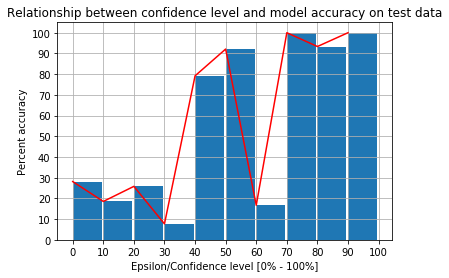

In [20]:
plt.plot(np.arange(0, 100, 100//N), error, 'red')
plt.bar(np.arange(0, 100, 100//N), error, width=100//N - .5, align='edge')
plt.yticks(np.arange(0, 110, 10))
plt.xticks(np.arange(0, 110, 100//N))
plt.xlabel("Epsilon/Confidence level [0% - 100%]")
plt.ylabel("Percent accuracy")
plt.title("Relationship between confidence level and model accuracy on test data")
plt.grid()
plt.show()

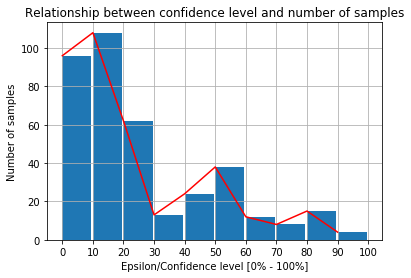

In [21]:
plt.plot(np.arange(0, 100, 100//N), samples, 'red')
plt.bar(np.arange(0, 100, 100//N), samples, width=100//N - .5, align='edge')
plt.xticks(np.arange(0, 110, 100//N))
plt.xlabel("Epsilon/Confidence level [0% - 100%]")
plt.ylabel("Number of samples")
plt.title("Relationship between confidence level and number of samples")
plt.grid()
plt.show()